# Sentence feature evolution, excluding stopwords

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = True
STOPWORDS = 'exclude'  # 'include' or 'exclude'

Setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('../..'))
import analysis

FIG = os.path.join(os.path.abspath(os.path.curdir), '{}.png')
DB_NAME = 'spreadr_' + os.path.split(os.path.abspath(os.path.curdir))[1]
analysis.setup(DB_NAME)
print('Database:', DB_NAME)

Database: spreadr_exp_3


Imports for the analysis

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Patch
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sb
from progressbar import ProgressBar

from gists.models import Sentence, Tree, GistsConfiguration

from analysis.utils import memoized, mpl_palette

config = GistsConfiguration.get_solo()
sb.set()
sb.set_style('whitegrid')

## 2 Long-term sentence feature evolution

### A note on the features used

The following features, defined on the sentences themselves, are used in the plots below:
* `token length`: number of words in the sentence.
* `content length`: number of content words in the sentence.
* `root memorable`: whether the root sentence was marked as a memorable quote or not.
* `oc rate`: "ordered content transformation rate". Measures how a sentence is transformed when rewritten. It's the levenshtein distance between the lists of content words of the sentence and its direct child, normalised to the maximum length of that list for child or parent. Depending on the graph, root sentences are counted as a single measure (with `oc rate` averaged over their children), or are counted as a separate measure for each child, whichever makes more sense.
* `oc transmitted`: "ordered content transmitted". Measures whether the list of content words of a sentence was transmitted perfectly or not (same words, same order). It's a boolean, represented as 0 or 1, and corresponds to `oc_rate == 0`. The same note above about root sentences applies.
* `ncoc rate`: "non-cropping ordered content transformation rate". Similar to the measure above, but factors out any sentence shortening in the distance computation, only measuring how much a sentence is transformed *on top of* shortening.
* `dep depth`: depth of the dependency tree of the sentence.
* `relatedness`: average distance between all pairs of content words in the sentence (distance is cosine between words' vector representations).
* `1 gram word`: cross-entropy of the sentence according to unigram language model trained on the newswire portion of the Brown corpus (as [Danescu-Niculescu-Mizil et al. (2012)](http://arxiv.org/abs/1203.6360) do). It's the negated average log-probability of the ngrams in the sentence, for this language model. In other words:
$$e = - \left< \log p\left( w \left| (n-1) \text{ preceding words} \right. \right) \right>_{w \in sentence}$$
where $p(w|\text{preceding words})$ is given by the language model, and $n$ is the size of the model's ngrams. So it measures how surprising the sentence's word sequence is, compared to the Brown newswire corpus.
* `2 gram word`: cross-entropy of the sentence according to bigram language model (same notes as above).
* `3 gram word`: cross-entropy of the sentence according to trigram language model (same notes as above).
* `1 gram tag`: cross-entropy of the sentence's POS tags according to unigram POS language model (same notes as above). Measures how surprising the sentence's POS sequence is, compared to the Brown newswire corpus. So its more a grammatical measure.
* `2 gram tag`: cross-entropy of the sentence's POS tags according to bigram POS language model (same notes as above).
* `3 gram tag`: cross-entropy of the sentence's POS tags according to trigram POS language model (same notes as above).

To all this we add features defined on words (frequency, age-of-acquisition, etc.), averaged over all words in the sentence (with or without stopwords, depending on the value of `STOPWORDS`).

"Content words", in the above, means "non-stopwords".

The idea here is to explore all the plots we can imagine, to have a global descriptive view. Depending on the graphs, the first five features may not appear if they don't make sense (or if they represent another dimension).

### 2.0 Setup

We need an additional feature-building function

In [4]:
def _stopword_proportion(self, _):
    """stopword %"""
    return 1 - (len(self.content_tokens) / len(self.tokens))

Sentence._stopword_proportion = _stopword_proportion
Sentence.SENTENCE_FEATURES.add('stopword_proportion')

Then build the master DataFrame that we'll plot below

In [5]:
def additional_features(sentence):
    return {
        'token_length': len(sentence.tokens),
        'content_length': len(sentence.content_tokens),
    }

def base(parent, child):
    return {
        # indices
        'tree_id': parent.tree.id,
        'sentence_id': parent.id,
        'branch_id': parent.head.id if parent.parent is not None else child.head.id,
        'child_id': child.id if child is not None else np.nan,
        # independent variables
        'depth': parent.depth,
        'is_root': parent.parent is None,
    }

def rows(parent, child):
    for fname in set(Sentence.WORD_FEATURES.keys())\
            .union(Sentence.SENTENCE_FEATURES)\
            .difference(['sentence_prop',
                         '1_gram_word', '1_gram_tag', '2_gram_word',
                         '2_gram_tag', '3_gram_word', '3_gram_tag',
                         'dep_depth', 'depth_above', 'depth_under',
                         'depth_prop', 'depth_subtree_prop']):
        row = base(parent, child)
        row.update(additional_features(sentence))
        row.update({'feature': fname, 'value': parent.feature(fname, stopwords=STOPWORDS)})
        yield row

In [6]:
data = []
for tree in ProgressBar(max_value=Tree.objects.experiment.count())(Tree.objects.experiment):
    for sentence in tree.sentences.kept:

        if sentence.depth > config.target_branch_depth:
            # Ignore out-of-shape sentences
            continue
        
        child_rows = []
        for child in sentence.children.kept:
            if child.depth > config.target_branch_depth:
                continue
            for row in rows(sentence, child):
                child_rows.append(row)
        for row in (child_rows or rows(sentence, None)):
            data.append(row)

data = pd.DataFrame(data)

features = sorted(set(data.feature))
index = sorted(set(data.columns).difference(['value', 'feature']))

N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/home/sl/Code/Research/interpretation-experiment/analysis/analysis/features.py:347: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.features(name, stopwords=stopwords))

100% (50 of 50) |#########################| Elapsed Time: 0:03:11 Time: 0:03:11


And define a few plotting functions

In [40]:
def plot_feature_evolution(x, y, **kwargs):
    color = kwargs.get('color', sb.color_palette()[0])
    data = kwargs['data']
    label = kwargs.get('label')
    ax = kwargs.get('ax', plt.gca())
    if 'sentence_id' in data.columns:
        # Average repeated measures (which we have for the roots)
        data = data.groupby('sentence_id', as_index=False).mean()
    x_y = data.groupby(x)[y]

    # Compute features per depth
    heights = x_y.mean()
    cis = (x_y.std(ddof=1)
           * stats.t.ppf(1 - .05/2, x_y.size() - 1)
           / np.sqrt(x_y.size()))

    # Plot
    ax.plot(heights.index, heights, color=color)

    ax.fill_between(heights.index, heights - cis, heights + cis,
                    color=sb.desaturate(color, 0.2), alpha=0.2)

    if label is not None:
        # Add a dummy scatterplot so we can get legend data
        ax.scatter([], [], color=color, label=label)
    return ax

### 2.2 Feature ~ depth

#### 2.2.1 Feature ~ depth

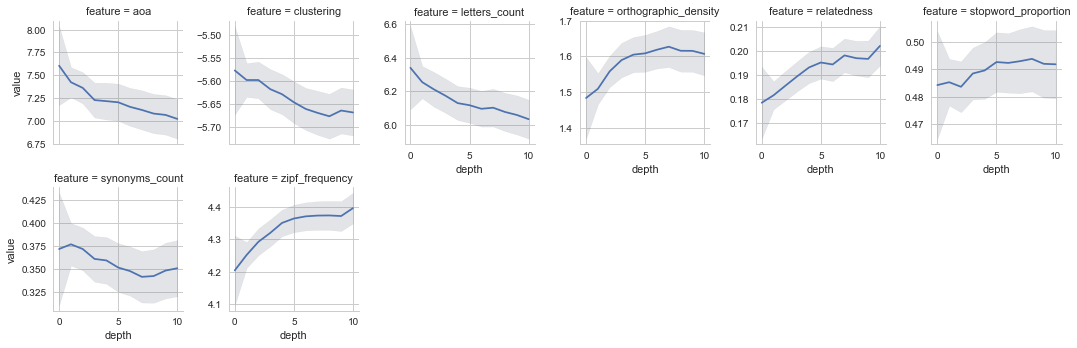

In [9]:
g = sb.FacetGrid(data=data,
                 dropna=False, col='feature', col_order=features,
                 col_wrap=6, size=2.5, sharey=False)
g.map_dataframe(plot_feature_evolution, 'depth', 'value')

#### 2.2.5 Feature ~ depth / number of content words

In [84]:
lims = {'aoa': [4.5, 9.5],
        'clustering': [-6.05, -5.25],
        'letters_count': [4.8, 7.2],
        'orthographic_density': [1, 2.3],
        'relatedness': [0.13, 0.3],
        'zipf_frequency': [3.75, 4.8],
        'stopword_proportion': [.38, .6],
        'synonyms_count': [.1, .55]}

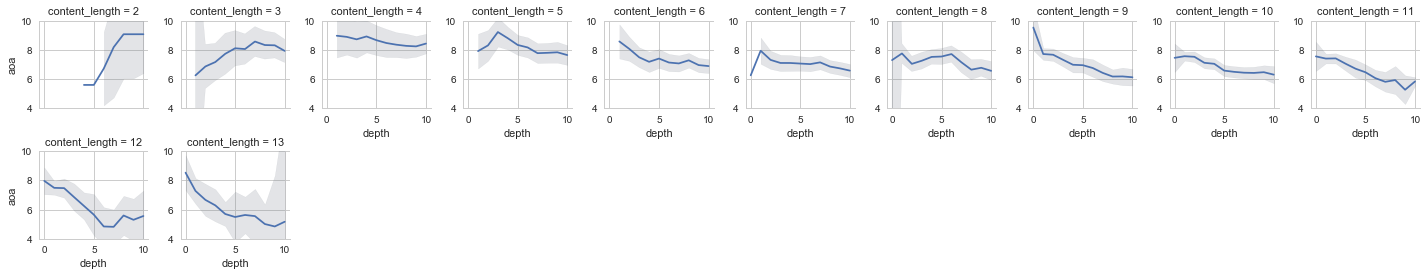

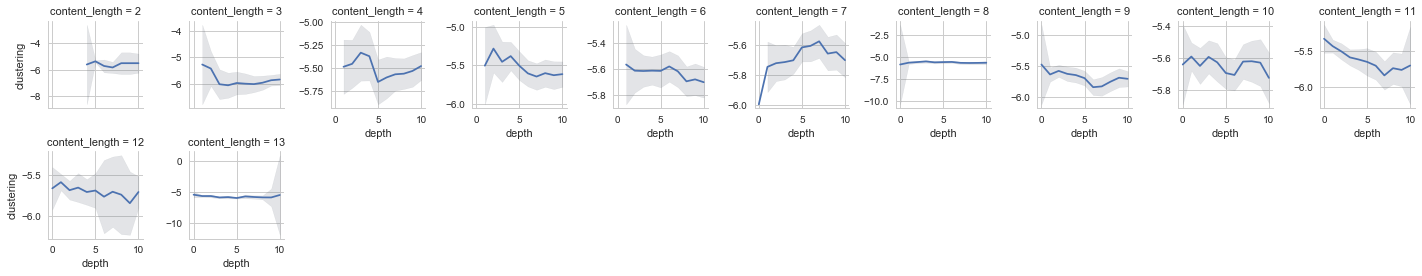

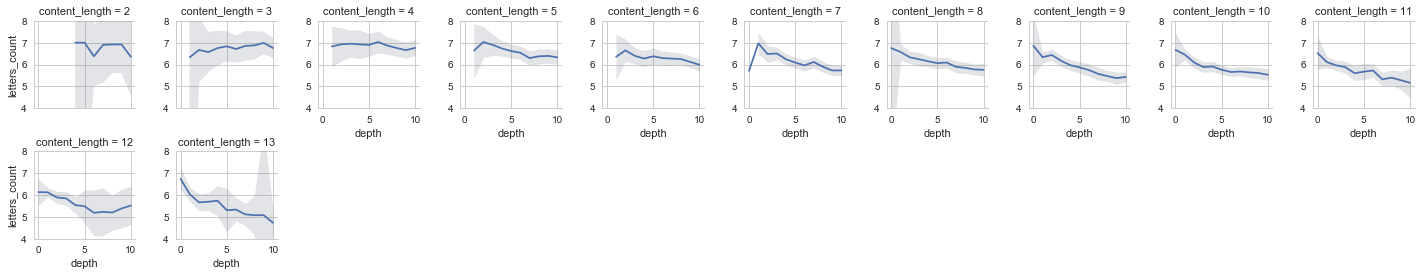

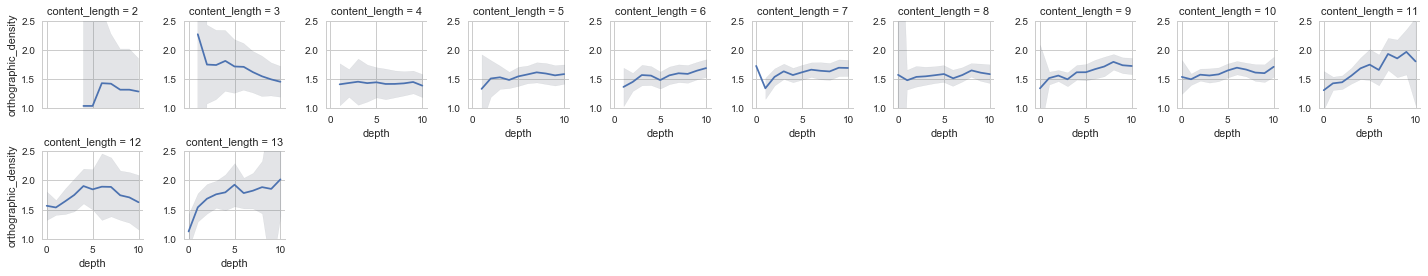

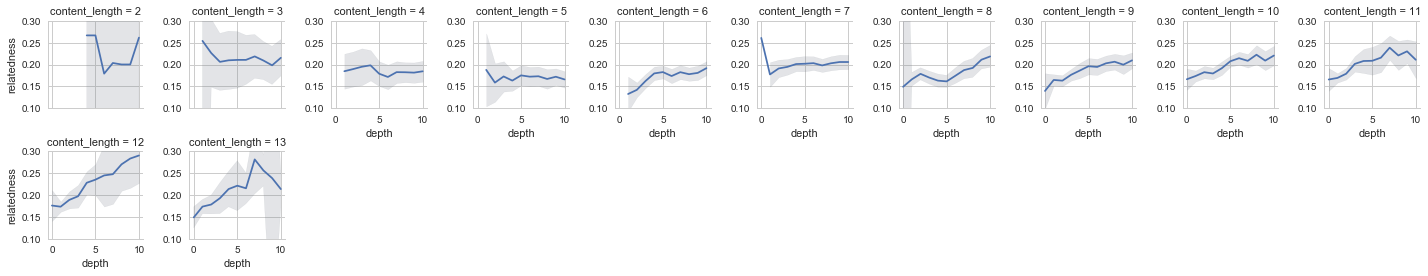

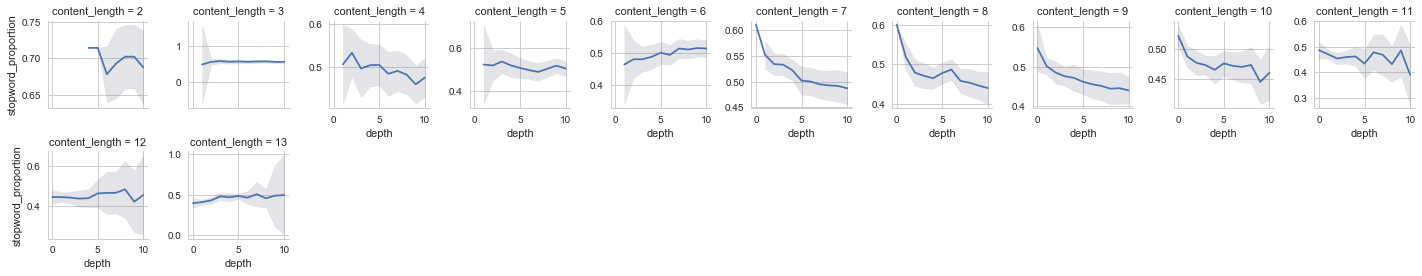

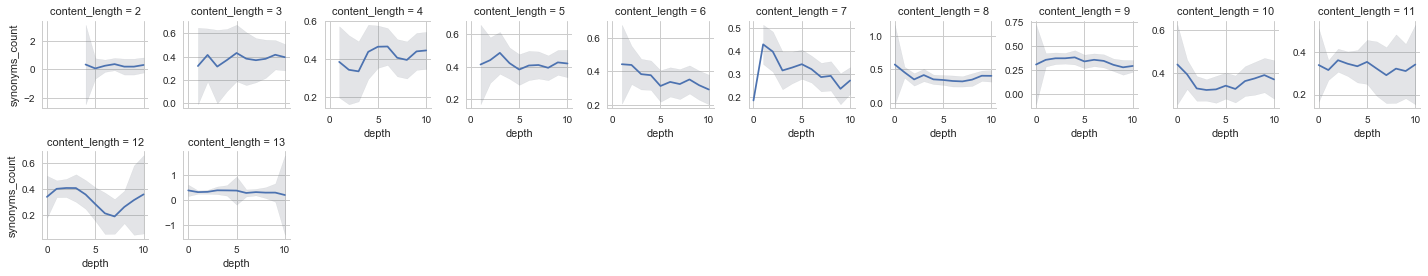

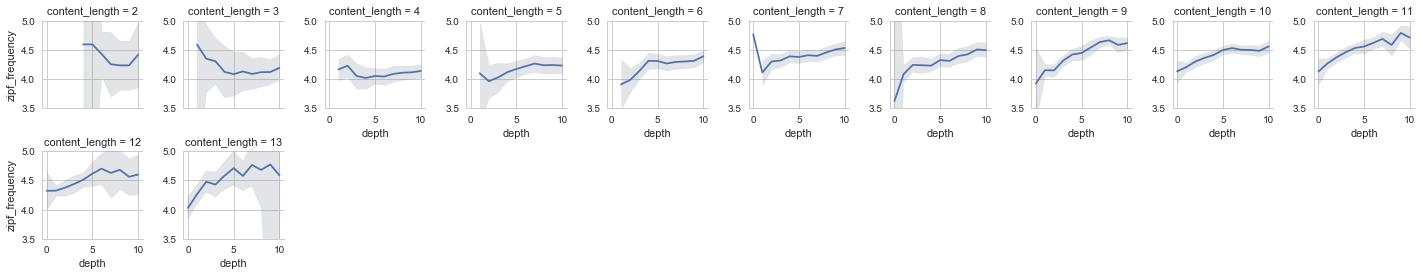

In [10]:
for feature in features:
    g = sb.FacetGrid(data=data[(data.feature == feature) & (data.content_length <= 13)],
                     dropna=False, col='content_length',
                     sharey=False,
                     col_wrap=10, size=2)
    g.map_dataframe(plot_feature_evolution, 'depth', 'value')
    g.set_ylabels(feature)
    if feature in lims:
        g.set(ylim=lims[feature])

In [11]:
def scale(bbox, add_width=.2):
    bbox = np.array(bbox)
    rest = 1 - add_width
    bbox[:,0] = 1 - (1 - bbox[:,0]) * rest
    return bbox

In [12]:
features

['aoa',
 'clustering',
 'letters_count',
 'orthographic_density',
 'relatedness',
 'stopword_proportion',
 'synonyms_count',
 'zipf_frequency']

In [89]:
main_width = 1 / 4

def paper_plot(data, col_wrap, xlim, ylim, col_order=None, color=sb.color_palette()[0]):
    main_margin = 1 / (10 * col_wrap)
    feature = data.iloc[0].feature
    
    if col_order is None:
        col_order = range(int(np.floor(data.content_length.min())),
                          int(np.ceil(data.content_length.max())) + 1)
    rows = int(np.ceil(len(col_order) / col_wrap))

    with sb.plotting_context('paper', font_scale=1):
        with sb.axes_style('whitegrid'):
            g = sb.FacetGrid(data=data, dropna=False,
                             col='content_length', col_order=col_order,
                             col_wrap=col_wrap,
                             size=1.5, margin_titles=True,
                             xlim=xlim, ylim=ylim,
                             aspect=rows / (col_wrap * main_width))
        g.map_dataframe(plot_feature_evolution, 'depth', 'value', color=color)
        g.set_ylabels('')
        g.set_xlabels('$d$')
        g.set_titles('$|c(u)|_w = {col_name}$')

    for (i,j,k), _ in g.facet_data():
        ax = g.facet_axis(i, j)
        bbox = scale(ax.get_position(), add_width=main_width + main_margin)
        ax.set_position([bbox[0,0], bbox[0,1], bbox[1,0]-bbox[0,0], bbox[1,1]-bbox[0,1]])
        ax.locator_params(integer=True, min_n_ticks=3)
    
    with sb.plotting_context('paper', font_scale=1.3):
        ax = plt.subplot2grid((1, int(1 / main_width)), (0, 0))
        plot_feature_evolution('depth', 'value', data=data, ax=ax, color=color)
        try:
            ax.set_ylabel(Sentence._transformed_word_feature(feature).__doc__)
        except AssertionError:
            ax.set_ylabel(feature)
        ax.set_xlabel('$d$')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.locator_params(integer=True, min_n_ticks=5)
        sb.despine()
    
    return g.fig

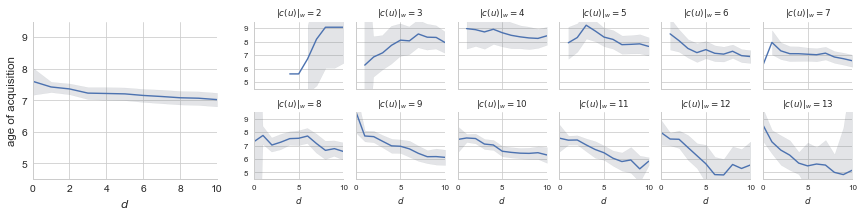

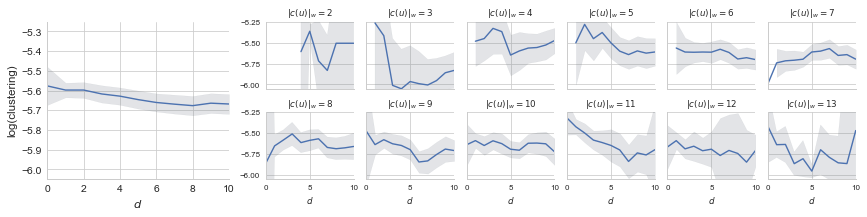

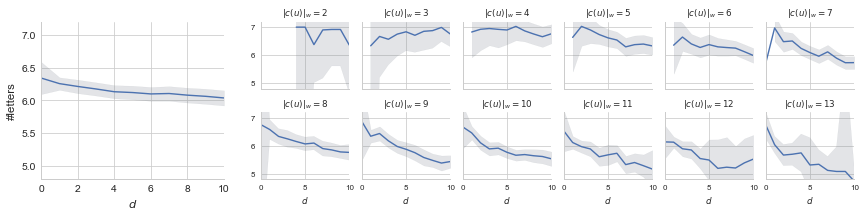

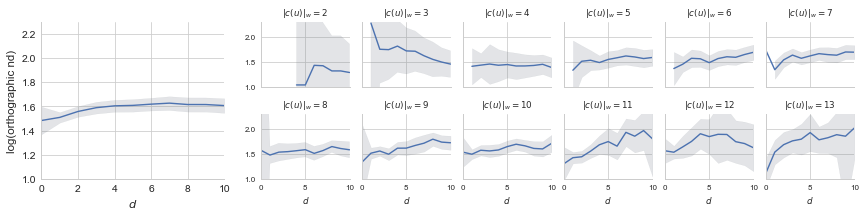

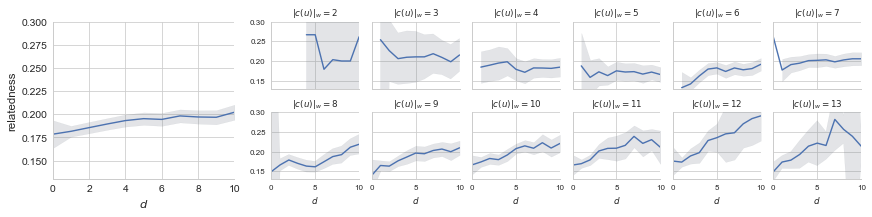

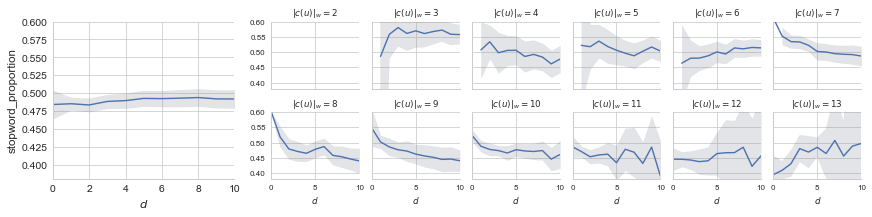

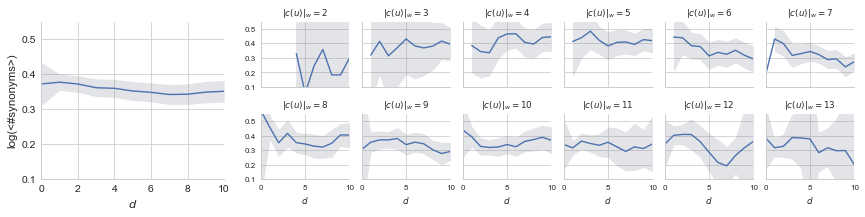

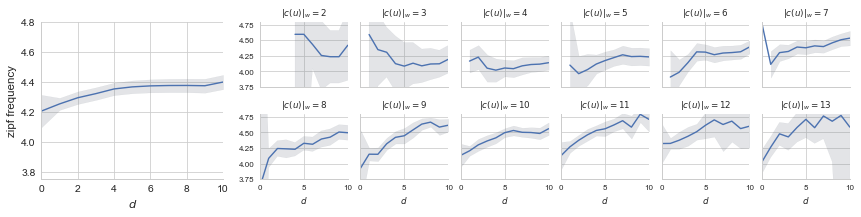

In [87]:
for feature in features:
    fig = paper_plot(data[data.feature == feature], 6, (0, 10),
                     lims[feature], col_order=range(2, 14))

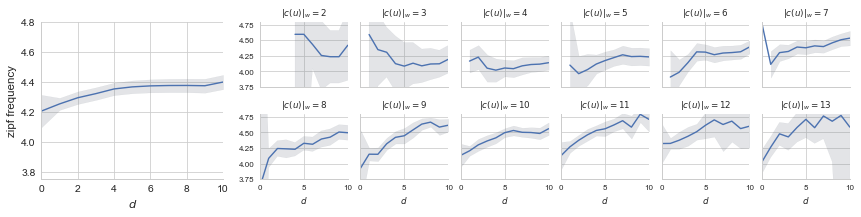

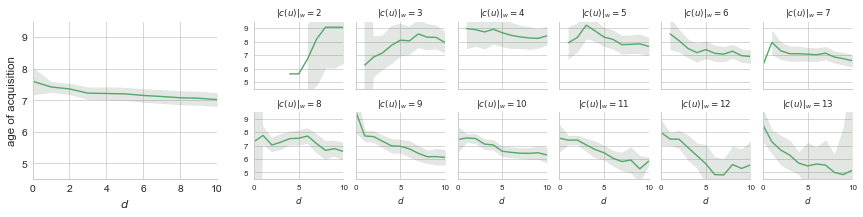

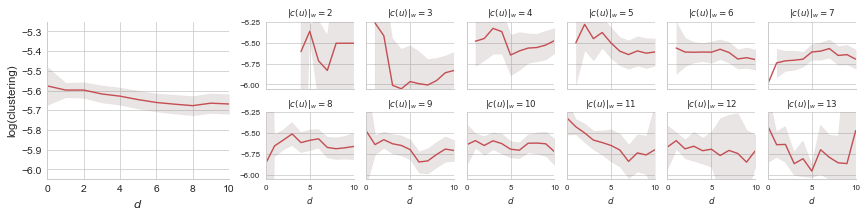

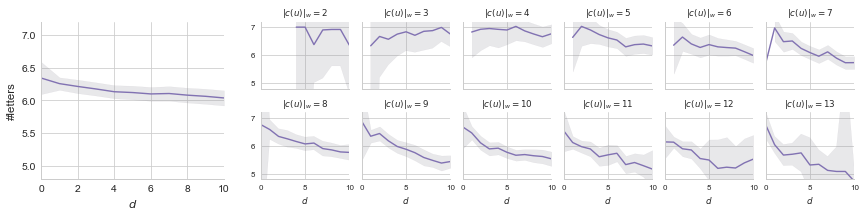

In [90]:
for i, feature in enumerate(['zipf_frequency', 'aoa', 'clustering', 'letters_count']):
    fig = paper_plot(data[data.feature == feature], 6, (0, 10),
                     lims[feature], col_order=range(2, 14), color=sb.color_palette()[i])
    if SAVE_FIGURES:
        fig.savefig('feature-branchevo-{}.png'.format(feature), dpi=300, bbox_inches='tight')